In [1]:
import xarray as xr
import gcsfs
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import time
from matplotlib.colors import LogNorm
from IPython.display import clear_output
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from intake import open_catalog

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

import pandas as pd
from timeit import default_timer as timer


In [2]:
plt.rcParams.update({'font.size': 14
    , 'legend.markerscale': 1., 'axes.titlesize': 14, 'axes.labelsize' : 12,
      'legend.fontsize' : 13,'legend.handlelength': 3})

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'
# plt.rcParams['figure.figsize'] = (14.,5.)



blue = cm.get_cmap('Blues', 256)
green = cm.get_cmap('Greens', 256)
red = cm.get_cmap('Reds', 256)
grey = cm.get_cmap('Greys', 256)
bone = cm.get_cmap('bone_r', 256)
binary = cm.get_cmap('binary', 256)
hot = cm.get_cmap('hot_r', 256)
gray = cm.get_cmap('gray_r', 256)


newcolors5 = blue(np.linspace(0, 1, 256))**2*grey(np.linspace(0, 1, 256))**0.2
newcmp5 = ListedColormap(newcolors5[::-1], name='BlueGrey')

newcolors7 = blue(np.linspace(0, 1, 256))**1.5*green(np.linspace(0, 1, 256))**0.3*grey(np.linspace(0, 1, 256))**0.03
newcmp7 = ListedColormap(newcolors7[::-1], name='BluegreenGrey')

newcmp6 = ListedColormap(newcolors5, name='BlueGrey_r')
newcmp8 = ListedColormap(newcolors7, name='BlueGreenGrey_r')

def plot_examples(cms):
    """
    helper function to plot two colormaps
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

In [3]:
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml")
ds  = cat["CESM_POP_hires_control"].to_dask()
# ds

In [4]:
ds = ds.rename({'U1_1':'U', 'V1_1':'V', 'TAUX_2':'TAUX', 'TAUY_2':'TAUY', 'SSH_2':'SSH', 'ULONG':'XU', 'ULAT':'YU'})

def make_3d_coords(lon,lat):
    X = np.sin(np.radians(lat))
    Y = np.sin(np.radians(lon))*np.cos(np.radians(lat))
    Z = -np.cos(np.radians(lon))*np.cos(np.radians(lat))
    return (X,Y,Z)

X, Y, Z = make_3d_coords(ds.XU.data, ds.YU.data)

ds['X'] = ds.XU.dims, X
ds['Y'] = ds.XU.dims, Y
ds['Z'] = ds.XU.dims, Z

def normalize_gridspacing(DX,DY):
    dX = (DX - np.mean(DX))/np.std(DX)
    dY = (DY - np.mean(DY))/np.std(DY)
    
    return (dX, dY)

dX, dY = normalize_gridspacing(ds.DXT.data, ds.DYT.data)

ds['dx'] = ds.XU.dims, dX
ds['dy'] = ds.XU.dims, dY

ds

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 14965, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HTE                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HTN                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HU                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HUS                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HUW                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    T0_Kelvin           float64 ...
    TAREA               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    UAREA               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    YU                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    XU                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    cp_air              float64 ...
    cp_sw               float64 ...
    days_in_norm_year   timedelta64[ns] ...
    dz                  (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    fwflux_factor       float64 ...
    grav                float64 ...
    heat_to_PW          float64 ...
    hflux_factor        float64 ...
    latent_heat_fusion  float64 ...
    latent_heat_vapor   float64 ...
    mass_to_Sv          float64 ...
    momentum_factor     float64 ...
    nsurface_t          float64 ...
    nsurface_u          float64 ...
    ocn_ref_salinity    float64 ...
    omega               float64 ...
    ppt_to_salt         float64 ...
    radius              float64 ...
    rho_air             float64 ...
    rho_fw              float64 ...
    rho_sw              float64 ...
    salinity_factor     float64 ...
    salt_to_Svppt       float64 ...
    salt_to_mmday       float64 ...
    salt_to_ppt         float64 ...
    sea_ice_salinity    float64 ...
    sflux_factor        float64 ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
  * time                (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:0...
    vonkar              float64 ...
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    HMXL_2              (time, 

In [5]:
def reshape_stencil(data, ssize):
    assert data.ndim == 2
    ny, nx = data.shape
    data_rs = data.reshape((ny//ssize, ssize,  nx//ssize, ssize))
    # move stencil to end
    data_mv = np.moveaxis(data_rs, 1, 2)
    data_flat = data_mv.reshape((-1, 2, 2))
    return data_flat

def extract_data(ds, vname, stencil_size, indexer):
    data = ds[vname].values
    data_rs = reshape_stencil(data, stencil_size)
    data_idx = data_rs[(slice(None),) + indexer]
    return data_idx

In [6]:

def prepare_data_2D(ds, apply_mask=True, randomize=True,stencil_size = 2,
                 stencil_vars = ['SSH', 'SST', 'X', 'Y', 'Z'], stencil_index = (slice(None), slice(None)),
                 point_vars = ['TAUX', 'TAUY'], point_index = (0, 0), 
                 target_vars = ['U', 'V'], target_index = (0, 0) ):
    
    stencil_data = [extract_data(ds, vname, stencil_size, stencil_index)
                    for vname in stencil_vars]
    point_data = [extract_data(ds, vname, stencil_size, point_index)
                   for vname in point_vars]
    target_data = [extract_data(ds, vname, stencil_size, target_index)
                   for vname in target_vars]

    if apply_mask:
        mask = np.isnan(stencil_data[0]).sum(axis=(1, 2)) == 0
    else:
        mask = slice(None)
    if randomize:
        random_idx = np.random.permutation(mask.sum())
    else:
        random_idx = slice(None)

    features_stencil = np.stack([data[mask][random_idx] for data in stencil_data],
                                axis=-1)
    features_point = np.stack([data[mask][random_idx] for data in point_data],
                               axis=-1)
    targets = np.stack([data[mask][random_idx] for data in target_data],
                        axis=-1)
    
    return [features_stencil, features_point], targets

In [7]:
def reshape_stencil(data, ssize):
    assert data.ndim == 2
    ny, nx = data.shape
    data_rs = data.reshape((ny//ssize, ssize,  nx//ssize, ssize))
    # move stencil to end
    data_mv = np.moveaxis(data_rs, 1, 2)
    data_flat = data_mv.reshape((-1, 2, 2))
    return data_flat

def reshape_stencil_time(data, ssize):
    assert data.ndim == 3
    nt, ny, nx = data.shape
    data_rs = data.reshape((nt, ny//ssize, ssize,  nx//ssize, ssize))
    # move stencil to end
    data_mv = np.moveaxis(np.moveaxis(data_rs, 2, 3), 0,4)
    data_flat = data_mv.reshape((-1, 2, 2, 3))
    return data_flat

def extract_data_loc(ds, vname, stencil_size, indexer):
    data = ds[vname].values
    data_rs = reshape_stencil(data, stencil_size)
    data_idx = data_rs[(slice(None),) + indexer]
    return data_idx

def extract_data_time(ds, vname, stencil_size, indexer):
    data = ds[vname].values
    data_rs = reshape_stencil_time(data, stencil_size)
    data_idx = data_rs[(slice(None),) + indexer]
    return data_idx

def prepare_data_3dpointloc(ds, apply_mask=True, randomize=True, stencil_size = 2,
                            stencil_time_vars = ['SSH',], stencil_time_index = (slice(None), slice(None), slice(None)),
                            point_vars = ['TAUX', 'TAUY'], point_index = (1, 0, 0), 
                            loc_vars = ['X','dx','dy'], loc_index = (0, 0), 
                            target_vars = ['U', 'V'], target_index = (1, 0, 0) ):
    
    stencil_time_data = [extract_data_time(ds, vname, stencil_size, stencil_time_index)
                    for vname in stencil_time_vars]    
    loc_data = [extract_data_loc(ds, vname, stencil_size, loc_index)
                    for vname in loc_vars]
    point_data = [extract_data_time(ds, vname, stencil_size, point_index)
                   for vname in point_vars]
    target_data = [extract_data_time(ds, vname, stencil_size, target_index)
                   for vname in target_vars]

    if apply_mask:
        mask = np.isnan(stencil_time_data[0]).sum(axis=(1, 2, 3)) == 0
    else:
        mask = slice(None)
    if randomize:
        random_idx = np.random.permutation(mask.sum())
    else:
        random_idx = slice(None)

    features_stencil_time = np.stack([data[mask][random_idx] for data in stencil_time_data],
                                axis=-1)
    features_loc = np.stack([data[mask][random_idx] for data in loc_data],
                                axis=-1)
    
    features_point = np.stack([data[mask][random_idx] for data in point_data],
                               axis=-1)
    targets = np.stack([data[mask][random_idx] for data in target_data],
                        axis=-1)
    return [features_stencil_time, features_point, features_loc], targets


def prepare_data_3dloc(ds, apply_mask=True, randomize=True, stencil_size = 2,
                            stencil_time_vars = ['SSH',], stencil_time_index = (slice(None), slice(None), slice(None)),
                            loc_vars = ['X','dx','dy'], loc_index = (0, 0), 
                            target_vars = ['U', 'V'], target_index = (1, 0, 0) ):
    
    stencil_time_data = [extract_data_time(ds, vname, stencil_size, stencil_time_index)
                    for vname in stencil_time_vars]    
    loc_data = [extract_data_loc(ds, vname, stencil_size, loc_index)
                    for vname in loc_vars]
    target_data = [extract_data_time(ds, vname, stencil_size, target_index)
                   for vname in target_vars]

    if apply_mask:
        mask = np.isnan(stencil_time_data[0]).sum(axis=(1, 2, 3)) == 0
    else:
        mask = slice(None)
    if randomize:
        random_idx = np.random.permutation(mask.sum())
    else:
        random_idx = slice(None)

    features_stencil_time = np.stack([data[mask][random_idx] for data in stencil_time_data],
                                axis=-1)
    features_loc = np.stack([data[mask][random_idx] for data in loc_data],
                                axis=-1)
    targets = np.stack([data[mask][random_idx] for data in target_data],
                        axis=-1)
    return [features_stencil_time, features_loc], targets


In [8]:
labels = {}

labels['00'] = 'SSH_2ps_pointTAUXTAUY_3l_402010_nf80'
labels['01'] = 'SSH_2ps_pointX_3l_402010_nf80'
labels['02'] = 'SSHSST_2ps_pointX_3l_402010_nf80'
labels['03'] = 'SSH_2ps_pointXTAUXTAUY_3l_402010_nf80'
labels['04'] = 'SSHSST_2ps_pointXTAUXTAUY_3l_402010_nf80'
labels['05'] = 'SSHXYZ_2ps_pointTAUXTAUY_3l_402010_nf80'
labels['06'] = 'SSHX_2ps_pointTAUXTAUY_3l_402010_nf80'
labels['07'] = 'SSHSSTXYZ_2ps_pointTAUXTAUY_3l_402010_nf80'
labels['08'] = 'SSHSSTX_2ps_pointTAUXTAUY_3l_402010_nf80'
labels['09'] = 'SSHTAUXTAUY_2ps_pointX_3l_402010_nf80'
labels['10'] = 'SSHSSTTAUXTAUY_2ps_pointX_3l_402010_nf80'
labels['11'] = 'SSHSST_2ps_pointXdxdyTAUXTAUY_3l_402010_nf80'


In [9]:
m2d_keys = ['00','01','02','03','04','05','06','07','08','09','10','11']


In [85]:
labels['12'] = 'SSHSSTSSS_2ps_pointXdxdyTAUXTAUY_3l_402010_nf80'


In [10]:
model = {}
history = {}
for r in m2d_keys:
    model[r] = keras.models.load_model('models/' + labels[r])
    history[r] = np.load('models/history_%s.npz' %labels[r])

In [86]:
for r in ['12']:
    model[r] = keras.models.load_model('models/' + labels[r])
    history[r] = np.load('models/history_%s.npz' %labels[r])

In [11]:
features_pred = {}
targets_true = {}
features_test = {}
targets_test = {}

In [12]:
features_pred = {}
targets_true = {}

In [13]:
%%time


features_test['00'], targets_test['00'] = prepare_data_2D(ds.isel(time=365*10+70), stencil_vars = ['SSH',], point_vars=['TAUX','TAUY',],
                                                          apply_mask=True, randomize=False,)
features_test['01'], targets_test['01'] = prepare_data_2D(ds.isel(time=365*10+70), stencil_vars = ['SSH',], point_vars=['X',],
                                                          apply_mask=True, randomize=False,)
features_test['02'], targets_test['02'] = prepare_data_2D(ds.isel(time=365*10+70), stencil_vars = ['SSH','SST',], point_vars=['X',],
                                                          apply_mask=True, randomize=False,)
features_test['03'], targets_test['03'] = prepare_data_2D(ds.isel(time=365*10+70), stencil_vars = ['SSH',], point_vars=['X','TAUX','TAUY',],
                                                          apply_mask=True, randomize=False,)
features_test['04'], targets_test['04'] = prepare_data_2D(ds.isel(time=365*10+70), stencil_vars = ['SSH','SST',], point_vars=['X','TAUX','TAUY'],
                                                          apply_mask=True, randomize=False,)
features_test['05'], targets_test['05'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','X','Y','Z'], point_vars=['TAUX','TAUY',],
                                                          apply_mask=True, randomize=False,)
features_test['06'], targets_test['06'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','X',], point_vars=['TAUX','TAUY',],
                                                          apply_mask=True, randomize=False,)
features_test['07'], targets_test['07'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','SST','X','Y','Z',], point_vars=['TAUX','TAUY'],
                                                          apply_mask=True, randomize=False,)
features_test['08'], targets_test['08'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','SST','X'], point_vars=['TAUX','TAUY'],
                                                          apply_mask=True, randomize=False,)
features_test['09'], targets_test['09'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','TAUX','TAUY',], point_vars=['X',],
                                                          apply_mask=True, randomize=False,)
features_test['10'], targets_test['10'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','SST','TAUX','TAUY',], point_vars=['X'],
                                                          apply_mask=True, randomize=False,)
features_test['11'], targets_test['11'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','SST',], point_vars=['X','dx','dy','TAUX','TAUY'],
                                                          apply_mask=True, randomize=False,)



CPU times: user 19.1 s, sys: 6.27 s, total: 25.4 s
Wall time: 29.8 s


In [87]:
features_test['12'], targets_test['12'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','SST','SSS'], point_vars=['X','dx','dy','TAUX','TAUY'],
                                                          apply_mask=True, randomize=False,)



In [14]:
meval = {}

In [15]:
for mnum in m2d_keys:
    meval[mnum] = model[mnum].evaluate(features_test[mnum], targets_test[mnum])


41967/41967 [==============================] - 51s 1ms/step - loss: 3.4967 - mean_absolute_error: 3.4967 - mean_squared_error: 36.2822 - accuracy: 0.8989


In [ ]:
# targets_pred = {}
# for mnum in model.keys():
#     start = timer()
#     targets_pred[mnum] = model[mnum].predict(features_pred[mnum])
#     end = timer()
#     print(mnum, end - start)

In [ ]:
# for mnum in model2.keys():
#     start = timer()
#     targets_pred[mnum] = model2[mnum].predict(features_pred[mnum])
#     end = timer()
#     print(mnum, end - start)

In [16]:
# mae2 = np.array([7.7946, 5.1257, 5.1260, 3.1067, 3.2977, 3.0840, 3.2387, 3.3040, 3.7069, 3.6339, 3.2265, 4.0232])
# mse2 = np.array([233.0203, 63.3984, 65.9020, 39.5688, 36.4640, 34.4702, 39.0651, 37.6900, 41.3248, 40.4397, 36.7599, 46.0133 ])
# acc2 = np.array([0.6970, 0.7765, 0.7963, 0.9063, 0.8699, 0.8924, 0.9052, 0.8779, 0.8557, 0.8388, 0.8937, 0.9123 ])

# mae3 = np.array([4.6787, 4.4783, 3.9713, 4.2278, 5.3598, 5.6873, 5.6739, 5.5928, 4.3509, 4.4022,])
# mse3 = np.array([56.4924, 51.5324, 44.7217, 53.1741, 66.6272, 77.8924, 72.7270, 72.9671, 52.9664, 54.0769])
# acc3 = np.array([0.8721, 0.8174, 0.8646, 0.8621, 0.7836, 0.7935, 0.7870, 0.8016, 0.8336, 0.8570])


loss_ev = {}
mse_ev = {}
acc_ev = {}
for r in meval.keys():
    loss_ev[r] = meval[r][0]
    mse_ev[r] = meval[r][2]
    acc_ev[r] = meval[r][-1]
# for i,r in enumerate(m2d_keys):
#     loss_ev[r] = mae2[i]
#     mse_ev[r] = mse2[i]
#     acc_ev[r] = acc2[i]
    
# for j,r in enumerate(m3d_keys):
#     loss_ev[r] = mae3[j]
#     mse_ev[r] = mse3[j]
#     acc_ev[r] = acc3[j]

In [19]:
colors = {'00': 'rosybrown', 
          '01' : 'royalblue', 
          '02' : 'mediumblue', 
          '03' : 'midnightblue', 
          '04' : 'slateblue', 
          '05' : 'mediumorchid', 
          '06': 'violet', 
          '07' : 'mediumvioletred', 
          '08' : 'crimson', 
          '09' : 'firebrick', 
          '10' : 'coral', 
          '11' : 'chocolate',
          
         }


In [ ]:
# history_all = {}
# for m2 in m2d_keys:
#     history_all[m2] = history[m2]
# for m3 in m3d_keys:
#     history_all[m3] = history2[m3]


In [20]:
plabels = {'00' : r'$\eta$ (2s), $\tau_x, \tau_y$ (point)', 
           '01' : r'$\eta$ (2s), $X$ (point)', 
           '02' : r'$\eta, \theta$ (2s), $X$ (point)', 
           '03' : r'$\eta$ (2s), $X, \tau_x, \tau_y$ (point)', 
           '04' : r'$\eta, \theta$ (2s), $X, \tau_x, \tau_y$ (point)', 
           '05' : r'$\eta, X, Y, Z$ (2s), $\tau_x, \tau_y$ (point)', 
           '06' : r'$\eta, X$ (2s), $\tau_x, \tau_y$ (point)', 
           '07' : r'$\eta, \theta, X, Y, Z$ (2s), $\tau_x, \tau_y$ (point)', 
           '08' : r'$\eta, \theta, X$ (2s), $\tau_x, \tau_y$ (point)', 
           '09' : r'$\eta, \tau_x, \tau_y$ (2s), $X$ (point)', 
           '10' : r'$\eta, \theta, \tau_x, \tau_y$ (2s), $X$ (point)', 
           '11' : r'$\eta, \theta$ (2s), $X, dx, dy, \tau_x, \tau_y$ (point)',  
#            '000' : r'$\eta$ (3t-2s), $X, dx, dy, \tau_x, \tau_y$ (point)', 
#            '001' : r'$\eta, \theta$ (3t-2s), $X, dx, dy, \tau_x, \tau_y$ (point)', 
#            '002' : r'$\eta$ (3t-2s), $X, \tau_x, \tau_y$ (point)', 
#            '003' : r'$\eta, \theta$ (3t-2s), $X, \tau_x, \tau_y$ (point)', 
#            '004' : r'$\eta$ (3t-2s), $X, dx, dy$ (point)', 
#            '005' : r'$\eta, \theta$ (3t-2s), $X, dx, dy$ (point)', 
#            '006' : r'$\eta$ (3t-2s), $X$ (point)', 
#            '007' : r'$\eta, \theta$ (3t-2s), $X$ (point)', 
#            '008' : r'$\eta, \theta, S$ (3t-2s), $X, \tau_x, \tau_y$ (point)', 
#            '009' : r'$\eta, \theta, S$ (3t-2s), $X, dx, dy, \tau_x, \tau_y$ (point)',
          }

In [17]:
import copy

In [18]:
features_test['11'], targets_test['11'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','SST',], point_vars=['X','dx','dy','TAUX','TAUY'],
                                                          apply_mask=True, randomize=False,)
features_pred['11'], targets_true['11'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','SST',], point_vars=['X','dx','dy','TAUX','TAUY'],
                                                          apply_mask=False, randomize=False,)


In [21]:
dvar = {}
dvar['11_deta1s'] = 1*np.std(features_test['11'][0][:,:,:,0])
dvar['11_deta2s'] = 2*np.std(features_test['11'][0][:,:,:,0])
dvar['11_deta05s'] = 0.5*np.std(features_test['11'][0][:,:,:,0])

dvar['11_dT1s'] = 1*np.std(features_test['11'][0][:,:,:,1])
dvar['11_dT2s'] = 2*np.std(features_test['11'][0][:,:,:,1])
dvar['11_dT05s'] = 0.5*np.std(features_test['11'][0][:,:,:,1])

dvar['11_dX1s'] = 1*np.std(features_test['11'][1][:,0])
dvar['11_dX2s'] = 2*np.std(features_test['11'][1][:,0])
dvar['11_dX05s'] = 0.5*np.std(features_test['11'][1][:,0])

dvar['11_ddx1s'] = 1*np.std(features_test['11'][1][:,1])
dvar['11_ddx2s'] = 2*np.std(features_test['11'][1][:,1])
dvar['11_ddx05s'] = 0.5*np.std(features_test['11'][1][:,1])

dvar['11_ddy1s'] = 1*np.std(features_test['11'][1][:,2])
dvar['11_ddy2s'] = 2*np.std(features_test['11'][1][:,2])
dvar['11_ddy05s'] = 0.5*np.std(features_test['11'][1][:,2])

dvar['11_dTAUX1s'] = 1*np.std(features_test['11'][1][:,3])
dvar['11_dTAUX2s'] = 2*np.std(features_test['11'][1][:,3])
dvar['11_dTAUX05s'] = 0.5*np.std(features_test['11'][1][:,3])

dvar['11_dTAUY1s'] = 1*np.std(features_test['11'][1][:,4])
dvar['11_dTAUY2s'] = 2*np.std(features_test['11'][1][:,4])
dvar['11_dTAUY05s'] = 0.5*np.std(features_test['11'][1][:,4])


In [41]:
%%time

features_test['11_deta1s'] = copy.deepcopy(features_test['11'])
features_test['11_deta2s'] = copy.deepcopy(features_test['11'])
features_test['11_deta05s'] = copy.deepcopy(features_test['11'])
features_test['11_dT1s'] = copy.deepcopy(features_test['11'])
features_test['11_dT2s'] = copy.deepcopy(features_test['11'])
features_test['11_dT05s'] = copy.deepcopy(features_test['11'])
features_test['11_dX1s'] = copy.deepcopy(features_test['11'])
features_test['11_dX2s'] = copy.deepcopy(features_test['11'])
features_test['11_dX05s'] = copy.deepcopy(features_test['11'])
features_test['11_dTAUX1s'] = copy.deepcopy(features_test['11'])
features_test['11_dTAUX2s'] = copy.deepcopy(features_test['11'])
features_test['11_dTAUX05s'] = copy.deepcopy(features_test['11'])
features_test['11_dTAUY1s'] = copy.deepcopy(features_test['11'])
features_test['11_dTAUY2s'] = copy.deepcopy(features_test['11'])
features_test['11_dTAUY05s'] = copy.deepcopy(features_test['11'])
features_test['11_ddx1s'] = copy.deepcopy(features_test['11'])
features_test['11_ddx2s'] = copy.deepcopy(features_test['11'])
features_test['11_ddx05s'] = copy.deepcopy(features_test['11'])
features_test['11_ddy1s'] = copy.deepcopy(features_test['11'])
features_test['11_ddy2s'] = copy.deepcopy(features_test['11'])
features_test['11_ddy05s'] = copy.deepcopy(features_test['11'])

features_test['11_deta1s'][0][:,:,:,0] = features_test['11'][0][:,:,:,0] + np.random.normal(0,1*np.std(features_test['11'][0][:,:,:,0]),features_test['11'][0][:,:,:,0].shape)
features_test['11_deta2s'][0][:,:,:,0] = features_test['11'][0][:,:,:,0] + np.random.normal(0,2*np.std(features_test['11'][0][:,:,:,0]),features_test['11'][0][:,:,:,0].shape)
features_test['11_deta05s'][0][:,:,:,0] = features_test['11'][0][:,:,:,0] + np.random.normal(0,0.5*np.std(features_test['11'][0][:,:,:,0]),features_test['11'][0][:,:,:,0].shape)
features_test['11_dT1s'][0][:,:,:,1] = features_test['11'][0][:,:,:,1]  + np.random.normal(0,1*np.std(features_test['11'][0][:,:,:,1]),features_test['11'][0][:,:,:,1].shape)
features_test['11_dT2s'][0][:,:,:,1] = features_test['11'][0][:,:,:,1]  + np.random.normal(0,2*np.std(features_test['11'][0][:,:,:,1]),features_test['11'][0][:,:,:,1].shape)
features_test['11_dT05s'][0][:,:,:,1] = features_test['11'][0][:,:,:,1]  + np.random.normal(0,0.5*np.std(features_test['11'][0][:,:,:,1]),features_test['11'][0][:,:,:,1].shape)


features_test['11_dX1s'][1][:,0] = features_test['11'][1][:,0] + np.random.normal(0,1*np.std(features_test['11'][1][:,0]),features_test['11'][1][:,0].shape)
features_test['11_dX2s'][1][:,0] = features_test['11'][1][:,0] + np.random.normal(0,2*np.std(features_test['11'][1][:,0]),features_test['11'][1][:,0].shape)
features_test['11_dX05s'][1][:,0] = features_test['11'][1][:,0] + np.random.normal(0,0.5*np.std(features_test['11'][1][:,0]),features_test['11'][1][:,0].shape)

features_test['11_ddx1s'][1][:,1] = features_test['11'][1][:,1] + np.random.normal(0,1*np.std(features_test['11'][1][:,1]),features_test['11'][1][:,1].shape)
features_test['11_ddx2s'][1][:,1] = features_test['11'][1][:,1] +  np.random.normal(0,2*np.std(features_test['11'][1][:,1]),features_test['11'][1][:,1].shape)
features_test['11_ddx05s'][1][:,1] = features_test['11'][1][:,1] + np.random.normal(0,0.5*np.std(features_test['11'][1][:,1]),features_test['11'][1][:,1].shape)

features_test['11_ddy1s'][1][:,2] = features_test['11'][1][:,2] + np.random.normal(0,1*np.std(features_test['11'][1][:,2]),features_test['11'][1][:,2].shape)
features_test['11_ddy2s'][1][:,2] = features_test['11'][1][:,2] + np.random.normal(0,2*np.std(features_test['11'][1][:,2]),features_test['11'][1][:,2].shape)
features_test['11_ddy05s'][1][:,2] = features_test['11'][1][:,2] + np.random.normal(0,0.5*np.std(features_test['11'][1][:,2]),features_test['11'][1][:,2].shape)

features_test['11_dTAUX1s'][1][:,3] = features_test['11'][1][:,3] + np.random.normal(0,1*np.std(features_test['11'][1][:,3]),features_test['11'][1][:,3].shape)
features_test['11_dTAUX2s'][1][:,3] = features_test['11'][1][:,3] + np.random.normal(0,2*np.std(features_test['11'][1][:,3]),features_test['11'][1][:,3].shape)
features_test['11_dTAUX05s'][1][:,3] = features_test['11'][1][:,3] + np.random.normal(0,0.5*np.std(features_test['11'][1][:,3]),features_test['11'][1][:,3].shape)

features_test['11_dTAUY1s'][1][:,4] = features_test['11'][1][:,4] + np.random.normal(0,1*np.std(features_test['11'][1][:,4]),features_test['11'][1][:,4].shape)
features_test['11_dTAUY2s'][1][:,4] = features_test['11'][1][:,4] + np.random.normal(0,2*np.std(features_test['11'][1][:,4]),features_test['11'][1][:,4].shape)
features_test['11_dTAUY05s'][1][:,4] = features_test['11'][1][:,4] + np.random.normal(0,0.5*np.std(features_test['11'][1][:,4]),features_test['11'][1][:,4].shape)



CPU times: user 2.81 s, sys: 935 ms, total: 3.75 s
Wall time: 3.75 s


In [42]:
m2d_dsigma_keys = ['11_deta1s', '11_deta2s', '11_deta05s', 
                   '11_dT1s', '11_dT2s', '11_dT05s', 
                   '11_dX1s', '11_dX2s', '11_dX05s', 
                   '11_ddx1s', '11_ddx2s', '11_ddx05s', 
                   '11_ddy1s', '11_ddy2s', '11_ddy05s', 
                   '11_dTAUX1s', '11_dTAUX2s', '11_dTAUX05s', 
                   '11_dTAUY1s', '11_dTAUY2s', '11_dTAUY05s', ]

In [43]:
m2d_dsigma_keys

['11_deta1s',
 '11_deta2s',
 '11_deta05s',
 '11_dT1s',
 '11_dT2s',
 '11_dT05s',
 '11_dX1s',
 '11_dX2s',
 '11_dX05s',
 '11_ddx1s',
 '11_ddx2s',
 '11_ddx05s',
 '11_ddy1s',
 '11_ddy2s',
 '11_ddy05s',
 '11_dTAUX1s',
 '11_dTAUX2s',
 '11_dTAUX05s',
 '11_dTAUY1s',
 '11_dTAUY2s',
 '11_dTAUY05s']

In [44]:
mev_dsigma = {}

for mnum in m2d_dsigma_keys:
    mev_dsigma[mnum] = model['11'].evaluate(features_test[mnum], targets_test['11'])


41967/41967 [==============================] - 52s 1ms/step - loss: 4.0175 - mean_absolute_error: 4.0175 - mean_squared_error: 43.4938 - accuracy: 0.8632


In [45]:
mev_dsigma['11'] = model['11'].evaluate(features_test['11'], targets_test['11'])

41967/41967 [==============================] - 52s 1ms/step - loss: 3.4967 - mean_absolute_error: 3.4967 - mean_squared_error: 36.2822 - accuracy: 0.8989


In [46]:
mev_ds_mae = {}
mev_ds_mse = {}
mev_ds_acc = {}
for r in mev_dsigma.keys():
    mev_ds_mae[r] = mev_dsigma[r][0]
    mev_ds_mse[r] = mev_dsigma[r][2]
    mev_ds_acc[r] = mev_dsigma[r][-1]
    

In [91]:
features_test['12_deta1s'] = copy.deepcopy(features_test['12'])
features_test['12_deta2s'] = copy.deepcopy(features_test['12'])
features_test['12_deta05s'] = copy.deepcopy(features_test['12'])
features_test['12_dT1s'] = copy.deepcopy(features_test['12'])
features_test['12_dT2s'] = copy.deepcopy(features_test['12'])
features_test['12_dT05s'] = copy.deepcopy(features_test['12'])
features_test['12_dS1s'] = copy.deepcopy(features_test['12'])
features_test['12_dS2s'] = copy.deepcopy(features_test['12'])
features_test['12_dS05s'] = copy.deepcopy(features_test['12'])
features_test['12_dX1s'] = copy.deepcopy(features_test['12'])
features_test['12_dX2s'] = copy.deepcopy(features_test['12'])
features_test['12_dX05s'] = copy.deepcopy(features_test['12'])
features_test['12_dTAUX1s'] = copy.deepcopy(features_test['12'])
features_test['12_dTAUX2s'] = copy.deepcopy(features_test['12'])
features_test['12_dTAUX05s'] = copy.deepcopy(features_test['12'])
features_test['12_dTAUY1s'] = copy.deepcopy(features_test['12'])
features_test['12_dTAUY2s'] = copy.deepcopy(features_test['12'])
features_test['12_dTAUY05s'] = copy.deepcopy(features_test['12'])
features_test['12_ddx1s'] = copy.deepcopy(features_test['12'])
features_test['12_ddx2s'] = copy.deepcopy(features_test['12'])
features_test['12_ddx05s'] = copy.deepcopy(features_test['12'])
features_test['12_ddy1s'] = copy.deepcopy(features_test['12'])
features_test['12_ddy2s'] = copy.deepcopy(features_test['12'])
features_test['12_ddy05s'] = copy.deepcopy(features_test['12'])

features_test['12_deta1s'][0][:,:,:,0] = features_test['12'][0][:,:,:,0] + np.random.normal(0,1*np.std(features_test['12'][0][:,:,:,0]),features_test['12'][0][:,:,:,0].shape)
features_test['12_deta2s'][0][:,:,:,0] = features_test['12'][0][:,:,:,0] + np.random.normal(0,2*np.std(features_test['12'][0][:,:,:,0]),features_test['12'][0][:,:,:,0].shape)
features_test['12_deta05s'][0][:,:,:,0] = features_test['12'][0][:,:,:,0] + np.random.normal(0,0.5*np.std(features_test['12'][0][:,:,:,0]),features_test['12'][0][:,:,:,0].shape)
features_test['12_dT1s'][0][:,:,:,1] = features_test['12'][0][:,:,:,1]  + np.random.normal(0,1*np.std(features_test['12'][0][:,:,:,1]),features_test['12'][0][:,:,:,1].shape)
features_test['12_dT2s'][0][:,:,:,1] = features_test['12'][0][:,:,:,1]  + np.random.normal(0,2*np.std(features_test['12'][0][:,:,:,1]),features_test['12'][0][:,:,:,1].shape)
features_test['12_dT05s'][0][:,:,:,1] = features_test['12'][0][:,:,:,1]  + np.random.normal(0,0.5*np.std(features_test['12'][0][:,:,:,1]),features_test['12'][0][:,:,:,1].shape)
features_test['12_dS1s'][0][:,:,:,1] = features_test['12'][0][:,:,:,1]  + np.random.normal(0,1*np.std(features_test['12'][0][:,:,:,2]),features_test['12'][0][:,:,:,2].shape)
features_test['12_dS2s'][0][:,:,:,1] = features_test['12'][0][:,:,:,1]  + np.random.normal(0,2*np.std(features_test['12'][0][:,:,:,2]),features_test['12'][0][:,:,:,2].shape)
features_test['12_dS05s'][0][:,:,:,1] = features_test['12'][0][:,:,:,1]  + np.random.normal(0,0.5*np.std(features_test['12'][0][:,:,:,2]),features_test['12'][0][:,:,:,2].shape)

features_test['12_dX1s'][1][:,0] = features_test['12'][1][:,0] + np.random.normal(0,1*np.std(features_test['12'][1][:,0]),features_test['12'][1][:,0].shape)
features_test['12_dX2s'][1][:,0] = features_test['12'][1][:,0] + np.random.normal(0,2*np.std(features_test['12'][1][:,0]),features_test['12'][1][:,0].shape)
features_test['12_dX05s'][1][:,0] = features_test['12'][1][:,0] + np.random.normal(0,0.5*np.std(features_test['12'][1][:,0]),features_test['12'][1][:,0].shape)
features_test['12_ddx1s'][1][:,1] = features_test['12'][1][:,1] + np.random.normal(0,1*np.std(features_test['12'][1][:,1]),features_test['12'][1][:,1].shape)
features_test['12_ddx2s'][1][:,1] = features_test['12'][1][:,1] +  np.random.normal(0,2*np.std(features_test['12'][1][:,1]),features_test['12'][1][:,1].shape)
features_test['12_ddx05s'][1][:,1] = features_test['12'][1][:,1] + np.random.normal(0,0.5*np.std(features_test['12'][1][:,1]),features_test['12'][1][:,1].shape)

features_test['12_ddy1s'][1][:,2] = features_test['12'][1][:,2] + np.random.normal(0,1*np.std(features_test['12'][1][:,2]),features_test['12'][1][:,2].shape)
features_test['12_ddy2s'][1][:,2] = features_test['12'][1][:,2] + np.random.normal(0,2*np.std(features_test['12'][1][:,2]),features_test['12'][1][:,2].shape)
features_test['12_ddy05s'][1][:,2] = features_test['12'][1][:,2] + np.random.normal(0,0.5*np.std(features_test['12'][1][:,2]),features_test['12'][1][:,2].shape)

features_test['12_dTAUX1s'][1][:,3] = features_test['12'][1][:,3] + np.random.normal(0,1*np.std(features_test['12'][1][:,3]),features_test['12'][1][:,3].shape)
features_test['12_dTAUX2s'][1][:,3] = features_test['12'][1][:,3] + np.random.normal(0,2*np.std(features_test['12'][1][:,3]),features_test['12'][1][:,3].shape)
features_test['12_dTAUX05s'][1][:,3] = features_test['12'][1][:,3] + np.random.normal(0,0.5*np.std(features_test['12'][1][:,3]),features_test['12'][1][:,3].shape)

features_test['12_dTAUY1s'][1][:,4] = features_test['12'][1][:,4] + np.random.normal(0,1*np.std(features_test['12'][1][:,4]),features_test['12'][1][:,4].shape)
features_test['12_dTAUY2s'][1][:,4] = features_test['12'][1][:,4] + np.random.normal(0,2*np.std(features_test['12'][1][:,4]),features_test['12'][1][:,4].shape)
features_test['12_dTAUY05s'][1][:,4] = features_test['12'][1][:,4] + np.random.normal(0,0.5*np.std(features_test['12'][1][:,4]),features_test['12'][1][:,4].shape)


In [92]:
m2d_dsigma_keys2 = ['12_deta1s', '12_deta2s', '12_deta05s',
                   '12_dT1s', '12_dT2s', '12_dT05s', 
                   '12_dS1s', '12_dS2s', '12_dS05s', 
                   '12_dX1s', '12_dX2s', '12_dX05s',
                   '12_ddx1s', '12_ddx2s', '12_ddx05s',
                   '12_ddy1s', '12_ddy2s', '12_ddy05s',
                   '12_dTAUX1s', '12_dTAUX2s', '12_dTAUX05s',
                   '12_dTAUY1s', '12_dTAUY2s', '12_dTAUY05s', ]

In [93]:
mev_dsigma2 = {}

for mnum in m2d_dsigma_keys2:
    mev_dsigma2[mnum] = model['12'].evaluate(features_test[mnum], targets_test['12'])

41967/41967 [==============================] - 57s 1ms/step - loss: 4.0523 - mean_absolute_error: 4.0523 - mean_squared_error: 45.4709 - accuracy: 0.8394


In [94]:
mev_dsigma2['12'] = model['12'].evaluate(features_test['12'], targets_test['12'])

41967/41967 [==============================] - 57s 1ms/step - loss: 3.4722 - mean_absolute_error: 3.4722 - mean_squared_error: 37.2861 - accuracy: 0.8612


In [97]:
mev_dsigma2.keys()

dict_keys(['12_deta1s', '12_deta2s', '12_deta05s', '12_dT1s', '12_dT2s', '12_dT05s', '12_dS1s', '12_dS2s', '12_dS05s', '12_dX1s', '12_dX2s', '12_dX05s', '12_ddx1s', '12_ddx2s', '12_ddx05s', '12_ddy1s', '12_ddy2s', '12_ddy05s', '12_dTAUX1s', '12_dTAUX2s', '12_dTAUX05s', '12_dTAUY1s', '12_dTAUY2s', '12_dTAUY05s', '12'])

In [100]:
mev_ds_mae2 = {}
mev_ds_mse2 = {}
mev_ds_acc2 = {}
dvar2 = {}
dvar2['12_deta1s'] = 1*np.std(features_test['12'][0][:,:,:,0])
dvar2['12_deta2s'] = 2*np.std(features_test['12'][0][:,:,:,0])
dvar2['12_deta05s'] = 0.5*np.std(features_test['12'][0][:,:,:,0])

dvar2['12_dT1s'] = 1*np.std(features_test['12'][0][:,:,:,1])
dvar2['12_dT2s'] = 2*np.std(features_test['12'][0][:,:,:,1])
dvar2['12_dT05s'] = 0.5*np.std(features_test['12'][0][:,:,:,1])

dvar2['12_dS1s'] = 1*np.std(features_test['12'][0][:,:,:,2])
dvar2['12_dS2s'] = 2*np.std(features_test['12'][0][:,:,:,2])
dvar2['12_dS05s'] = 0.5*np.std(features_test['12'][0][:,:,:,2])

dvar2['12_dX1s'] = 1*np.std(features_test['12'][1][:,0])
dvar2['12_dX2s'] = 2*np.std(features_test['12'][1][:,0])
dvar2['12_dX05s'] = 0.5*np.std(features_test['12'][1][:,0])

dvar2['12_ddx1s'] = 1*np.std(features_test['12'][1][:,1])
dvar2['12_ddx2s'] = 2*np.std(features_test['12'][1][:,1])
dvar2['12_ddx05s'] = 0.5*np.std(features_test['12'][1][:,1])

dvar2['12_ddy1s'] = 1*np.std(features_test['12'][1][:,2])
dvar2['12_ddy2s'] = 2*np.std(features_test['12'][1][:,2])
dvar2['12_ddy05s'] = 0.5*np.std(features_test['12'][1][:,2])

dvar2['12_dTAUX1s'] = 1*np.std(features_test['12'][1][:,3])
dvar2['12_dTAUX2s'] = 2*np.std(features_test['12'][1][:,3])
dvar2['12_dTAUX05s'] = 0.5*np.std(features_test['12'][1][:,3])

dvar2['12_dTAUY1s'] = 1*np.std(features_test['12'][1][:,4])
dvar2['12_dTAUY2s'] = 2*np.std(features_test['12'][1][:,4])
dvar2['12_dTAUY05s'] = 0.5*np.std(features_test['12'][1][:,4])


for r in mev_dsigma2.keys():
    mev_ds_mae2[r] = mev_dsigma2[r][0]
    mev_ds_mse2[r] = mev_dsigma2[r][2]
    mev_ds_acc2[r] = mev_dsigma2[r][-1]
    


In [101]:
dvar2

{'12_deta1s': 80.69599914550781,
 '12_deta2s': 161.39199829101562,
 '12_deta05s': 40.347999572753906,
 '12_dT1s': 10.82296085357666,
 '12_dT2s': 21.64592170715332,
 '12_dT05s': 5.41148042678833,
 '12_dS1s': 2.4386284351348877,
 '12_dS2s': 4.877256870269775,
 '12_dS05s': 1.2193142175674438,
 '12_dX1s': 0.6747155077427388,
 '12_dX2s': 1.3494310154854776,
 '12_dX05s': 0.3373577538713694,
 '12_ddx1s': 0.6097667951914343,
 '12_ddx2s': 1.2195335903828686,
 '12_ddx05s': 0.30488339759571714,
 '12_ddy1s': 0.5708296645318798,
 '12_ddy2s': 1.1416593290637596,
 '12_ddy05s': 0.2854148322659399,
 '12_dTAUX1s': 1.2998861340710572,
 '12_dTAUX2s': 2.5997722681421145,
 '12_dTAUX05s': 0.6499430670355286,
 '12_dTAUY1s': 1.0634313247992315,
 '12_dTAUY2s': 2.126862649598463,
 '12_dTAUY05s': 0.5317156623996158}

In [106]:
dMdvar_0 = {}
dMdvar_1 = {}
dMdvar_2 = {}
for r in m2d_dsigma_keys2:
    dMdvar_0[r] = (mev_ds_mae2[r] - mev_ds_mae2['12'])/ dvar2[r]    
    dMdvar_1[r] = (mev_ds_mse2[r] - mev_ds_mse2['12'])/ dvar2[r]    
    dMdvar_2[r] = (mev_ds_acc2[r] - mev_ds_acc2['12'])/ dvar2[r]    


In [110]:
np.array(list(dMdvar_0.values()))[2::3]

array([4.23598976, 0.72213612, 0.36953178, 5.23552763, 0.21019904,
       0.32717616, 1.05913416, 1.09113665])

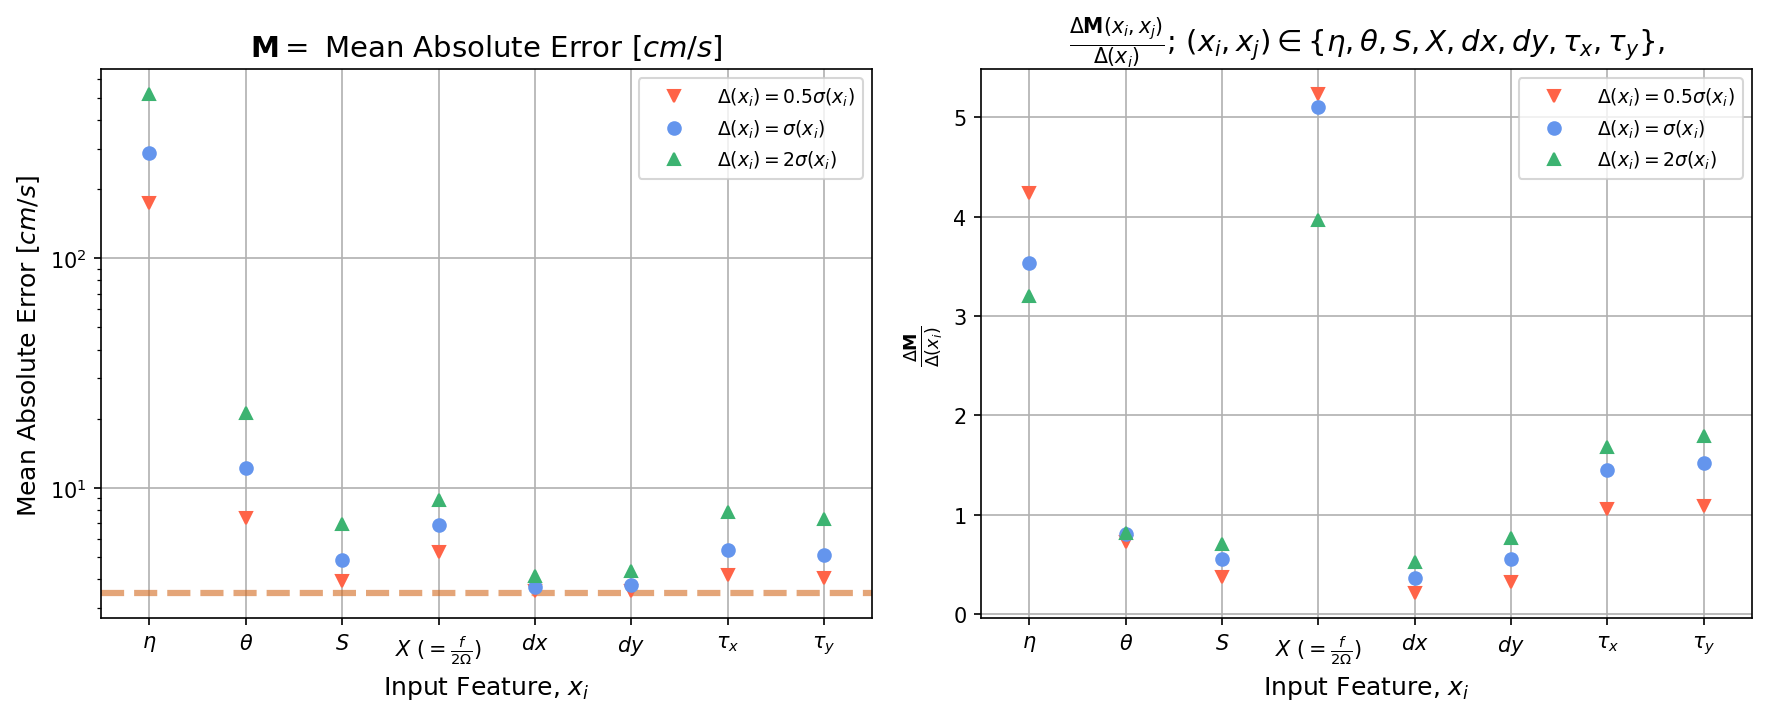

In [117]:
plt.figure(figsize=(12,5), tight_layout=True, dpi = 150)
xlabs = [r'$ \eta$', r'$ \theta$', r'$S$', r'$ X$ $(=\frac{f}{2\Omega})$', r'$ dx$', r'$ dy$', r'$ \tau_x$', r'$ \tau_y$' ]
ylabs = [r'$\Delta(x_i) = 0.5\sigma(x_i)$', r'$\Delta(x_i) = \sigma(x_i)$', r'$\Delta(x_i) =2 \sigma(x_i)$', ]

plt.subplot(121)
plt.plot(np.array(list(mev_ds_mae2.values()))[0:-1][2::3], 'v', label= ylabs[0], color=color1)
plt.plot(np.array(list(mev_ds_mae2.values()))[0:-1][::3], 'o', label= ylabs[1], color=color2)
plt.plot(np.array(list(mev_ds_mae2.values()))[0:-1][1::3], '^', label= ylabs[2], color=color3)
plt.hlines(np.array(list(mev_ds_mae2.values()))[-1], -0.5, 7.5, linestyle = 'dashed', linewidth=3, alpha=0.6, color = colors['11'])
plt.xticks([0,1,2,3,4,5,6,7], xlabs)
plt.xlabel(r'Input Feature, $x_i$ ')
plt.ylabel(r'Mean Absolute Error $[cm/s]$ ')
plt.yscale('log')
plt.xlim([-0.5,7.5])
plt.grid()
plt.legend(fontsize=9)
plt.title(r'$ \mathbf{M} =$ Mean Absolute Error $[cm/s]$')

plt.subplot(122)
plt.plot(np.array(list(dMdvar_0.values()))[2::3], 'v', label= ylabs[0], color=color1,)
plt.plot(np.array(list(dMdvar_0.values()))[::3], 'o', label= ylabs[1], color=color2,)
plt.plot(np.array(list(dMdvar_0.values()))[1::3], '^', label= ylabs[2], color=color3, )
plt.xticks([0,1,2,3,4,5,6,7], xlabs)
plt.xlabel(r'Input Feature, $x_i$ ')
plt.ylabel(r'$\frac{\Delta \mathbf{M}}{\Delta (x_i)}$ ')
plt.title(r'$\frac{\Delta \mathbf{M}(x_i,x_j)}{\Delta (x_i)}$; $(x_i, x_j) \in \{\eta,\theta,S,X,dx,dy,\tau_x,\tau_y\}$,' )
plt.xlim([-0.5,7.5])
plt.grid()
plt.legend(fontsize=9)
# plt.title(r'$\frac{\Delta \mathbf{M}}{\Delta \mathbf{x_i}}$, $\mathbf{x_i} \in \{\eta,\theta,X,dx,dy,\tau_x,\tau_y\}$')



In [113]:
np.array(list(mev_ds_mae2.values()))

array([288.40109253, 520.05981445, 174.38587952,  12.13976383,
        21.22443199,   7.37999201,   4.82315874,   6.91622734,
         3.92274189,   6.91451311,   8.82761955,   5.23841238,
         3.69217658,   4.1145196 ,   3.53625274,   3.78770065,
         4.34527826,   3.56554747,   5.35130167,   7.84004211,
         4.16054344,   5.08994246,   7.28105164,   4.05234098,
         3.47216654])

In [103]:
mev_dsigma2.keys()

dict_keys(['12_deta1s', '12_deta2s', '12_deta05s', '12_dT1s', '12_dT2s', '12_dT05s', '12_dS1s', '12_dS2s', '12_dS05s', '12_dX1s', '12_dX2s', '12_dX05s', '12_ddx1s', '12_ddx2s', '12_ddx05s', '12_ddy1s', '12_ddy2s', '12_ddy05s', '12_dTAUX1s', '12_dTAUX2s', '12_dTAUX05s', '12_dTAUY1s', '12_dTAUY2s', '12_dTAUY05s', '12'])

['12_deta1s',
 '12_deta2s',
 '12_deta05s',
 '12_dT1s',
 '12_dT2s',
 '12_dT05s',
 '12_dS1s',
 '12_dS2s',
 '12_dS05s',
 '12_dX1s',
 '12_dX2s',
 '12_dX05s',
 '12_ddx1s',
 '12_ddx2s',
 '12_ddx05s',
 '12_ddy1s',
 '12_ddy2s',
 '12_ddy05s',
 '12_dTAUX1s',
 '12_dTAUX2s',
 '12_dTAUX05s',
 '12_dTAUY1s',
 '12_dTAUY2s',
 '12_dTAUY05s']

In [50]:
dMdvar = {}
for r in m2d_dsigma_keys:
    dMdvar[r] = (mev_ds_mae[r] - mev_ds_mae['11'])/ dvar[r]

In [76]:
dMdvar2 = {}
for r in m2d_dsigma_keys:
    dMdvar2[r] = (mev_ds_mse[r] - mev_ds_mse['11'])/ dvar[r]
dMdvar3 = {}
for r in m2d_dsigma_keys:
    dMdvar3[r] = (mev_ds_acc[r] - mev_ds_acc['11'])/ dvar[r]

In [47]:
xlabs = [r'$\Delta \eta$', r'$\Delta \theta$', r'$\Delta X$', r'$\Delta dx$', r'$\Delta dy$', r'$\Delta \tau_x$', r'$\Delta \tau_y$' ]
ylabs = [r'$\Delta = 0.5\sigma$', r'$\Delta = 1\sigma$', r'$\Delta =2 \sigma$', ]

Text(0.5, 1.0, 'Model Accuracy $[\\%]$')

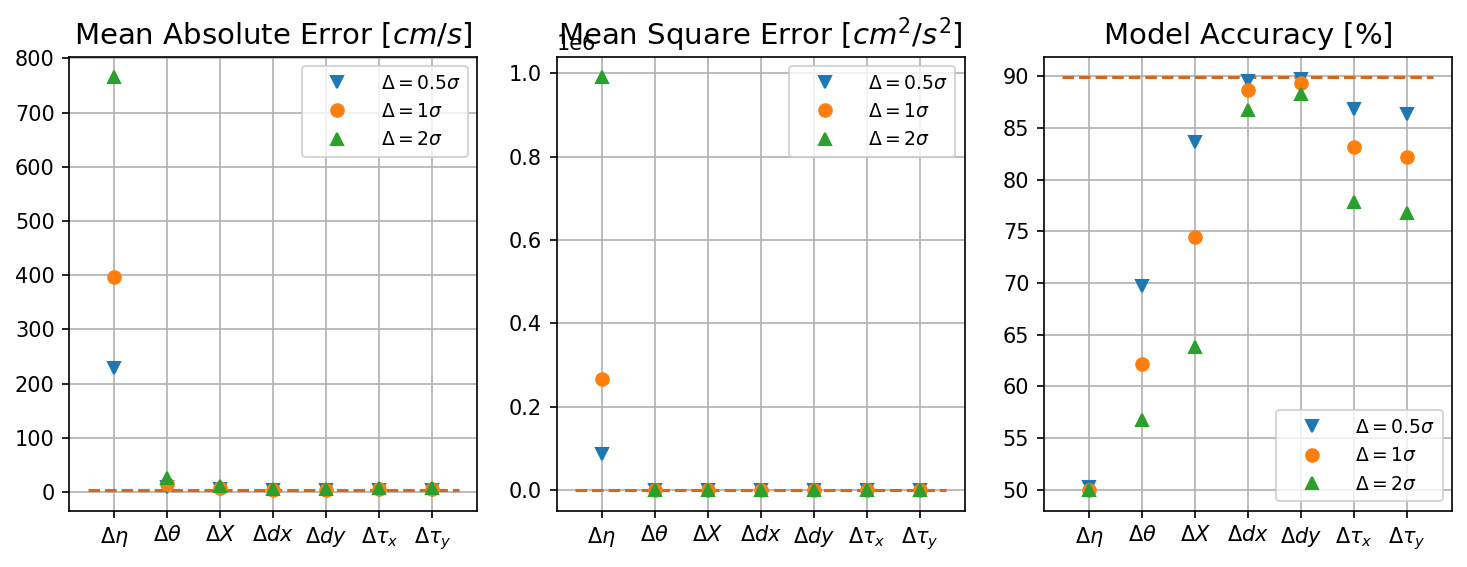

In [49]:
plt.figure(figsize=(10,4), tight_layout=True, dpi = 150)

plt.subplot(131)
plt.plot(np.array(list(mev_ds_mae.values()))[0:-1][2::3], 'v', label= ylabs[0])
plt.plot(np.array(list(mev_ds_mae.values()))[0:-1][::3], 'o', label= ylabs[1])
plt.plot(np.array(list(mev_ds_mae.values()))[0:-1][1::3], '^', label= ylabs[2])
plt.hlines(np.array(list(mev_ds_mae.values()))[-1], -0.5, 6.5, linestyle = 'dashed', color = colors['11'])
plt.xticks([0,1,2,3,4,5,6], xlabs)
plt.grid()
plt.legend(fontsize=9)
plt.title(r'Mean Absolute Error $[cm/s]$')


plt.subplot(132)
plt.plot(np.array(list(mev_ds_mse.values()))[0:-1][2::3], 'v', label= ylabs[0])
plt.plot(np.array(list(mev_ds_mse.values()))[0:-1][::3], 'o', label= ylabs[1])
plt.plot(np.array(list(mev_ds_mse.values()))[0:-1][1::3], '^', label= ylabs[2])
plt.hlines(np.array(list(mev_ds_mse.values()))[-1], -0.5, 6.5, linestyle = 'dashed', color = colors['11'])
plt.xticks([0,1,2,3,4,5,6] , xlabs)
plt.grid()
plt.legend(fontsize=9)
plt.title(r'Mean Square Error $[cm^2/s^2]$')


plt.subplot(133)
plt.plot(np.array(list(mev_ds_acc.values()))[0:-1][2::3]*100, 'v', label= ylabs[0])
plt.plot(np.array(list(mev_ds_acc.values()))[0:-1][::3]*100, 'o', label= ylabs[1])
plt.plot(np.array(list(mev_ds_acc.values()))[0:-1][1::3]*100, '^', label= ylabs[2])
plt.hlines(np.array(list(mev_ds_acc.values()))[-1]*100, -0.5, 6.5, linestyle = 'dashed', color = colors['11'])
plt.xticks([0,1,2,3,4,5,6] , xlabs)
plt.grid()
plt.legend(fontsize=9)
plt.title(r'Model Accuracy $[\%]$')



Text(0.5, 1.0, 'Mean Absolute Error $[cm/s]$')

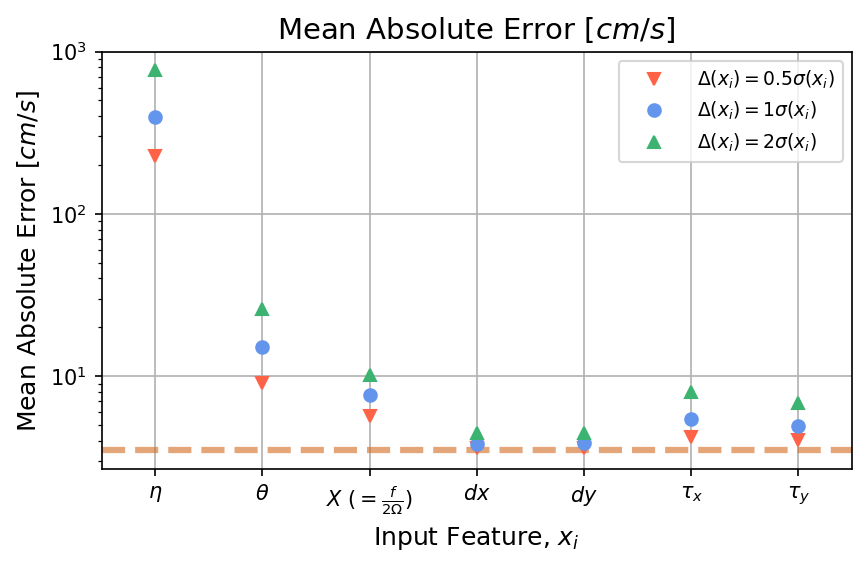

In [68]:
plt.figure(figsize=(6,4), tight_layout=True, dpi = 150)
xlabs = [r'$ \eta$', r'$ \theta$', r'$ X$ $(=\frac{f}{2\Omega})$', r'$ dx$', r'$ dy$', r'$ \tau_x$', r'$ \tau_y$' ]
ylabs = [r'$\Delta(x_i) = 0.5\sigma(x_i)$', r'$\Delta(x_i) = 1\sigma(x_i)$', r'$\Delta(x_i) =2 \sigma(x_i)$', ]

plt.plot(np.array(list(mev_ds_mae.values()))[0:-1][2::3], 'v', label= ylabs[0], color=color1)
plt.plot(np.array(list(mev_ds_mae.values()))[0:-1][::3], 'o', label= ylabs[1], color=color2)
plt.plot(np.array(list(mev_ds_mae.values()))[0:-1][1::3], '^', label= ylabs[2], color=color3)
plt.hlines(np.array(list(mev_ds_mae.values()))[-1], -0.5, 6.5, linestyle = 'dashed', linewidth=3, alpha=0.6, color = colors['11'])
plt.xticks([0,1,2,3,4,5,6], xlabs)
plt.xlabel(r'Input Feature, $x_i$ ')
plt.ylabel(r'Mean Absolute Error $[cm/s]$ ')
plt.yscale('log')
plt.xlim([-0.5,6.5])
plt.grid()
plt.legend(fontsize=9)
plt.title(r'Mean Absolute Error $[cm/s]$')



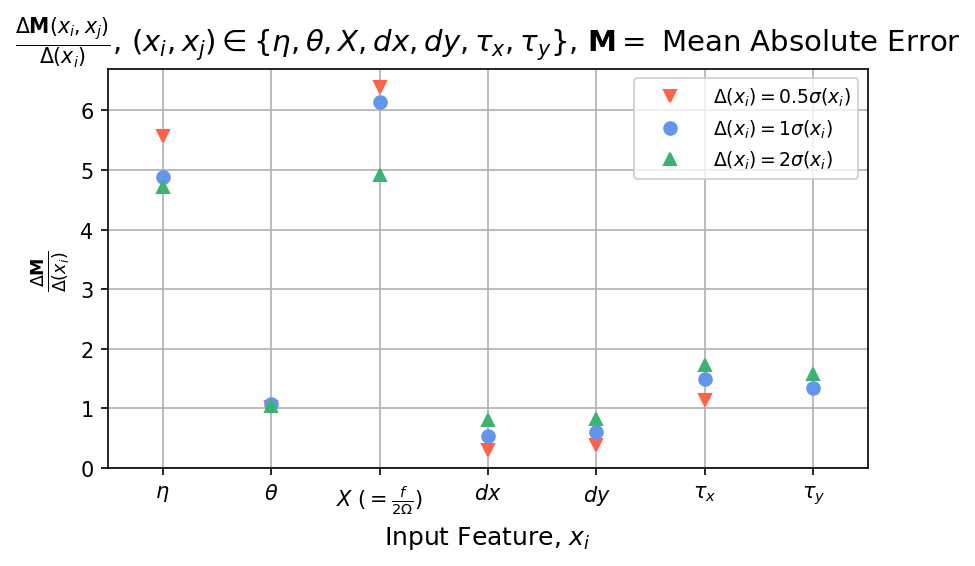

In [79]:
plt.figure(figsize=(6,4), tight_layout=True, dpi = 150)
xlabs = [r'$ \eta$', r'$ \theta$', r'$ X$ $(=\frac{f}{2\Omega})$', r'$ dx$', r'$ dy$', r'$ \tau_x$', r'$ \tau_y$' ]
ylabs = [r'$\Delta(x_i) = 0.5\sigma(x_i)$', r'$\Delta(x_i) = 1\sigma(x_i)$', r'$\Delta(x_i) =2 \sigma(x_i)$', ]

plt.plot(np.array(list(dMdvar.values()))[0:-1][2::3], 'v', label= ylabs[0], color=color1,)
plt.plot(np.array(list(dMdvar.values()))[0:-1][::3], 'o', label= ylabs[1], color=color2,)
plt.plot(np.array(list(dMdvar.values()))[0:-1][1::3], '^', label= ylabs[2], color=color3, )
plt.xticks([0,1,2,3,4,5,6], xlabs)
plt.xlabel(r'Input Feature, $x_i$ ')
plt.ylabel(r'$\frac{\Delta \mathbf{M}}{\Delta (x_i)}$ ')
plt.title(r'$\frac{\Delta \mathbf{M}(x_i,x_j)}{\Delta (x_i)}$, $(x_i, x_j) \in \{\eta,\theta,X,dx,dy,\tau_x,\tau_y\}$, $ \mathbf{M} =$ Mean Absolute Error ')
plt.xlim([-0.5,6.5])
plt.grid()
plt.legend(fontsize=9)
# plt.title(r'$\frac{\Delta \mathbf{M}}{\Delta \mathbf{x_i}}$, $\mathbf{x_i} \in \{\eta,\theta,X,dx,dy,\tau_x,\tau_y\}$')



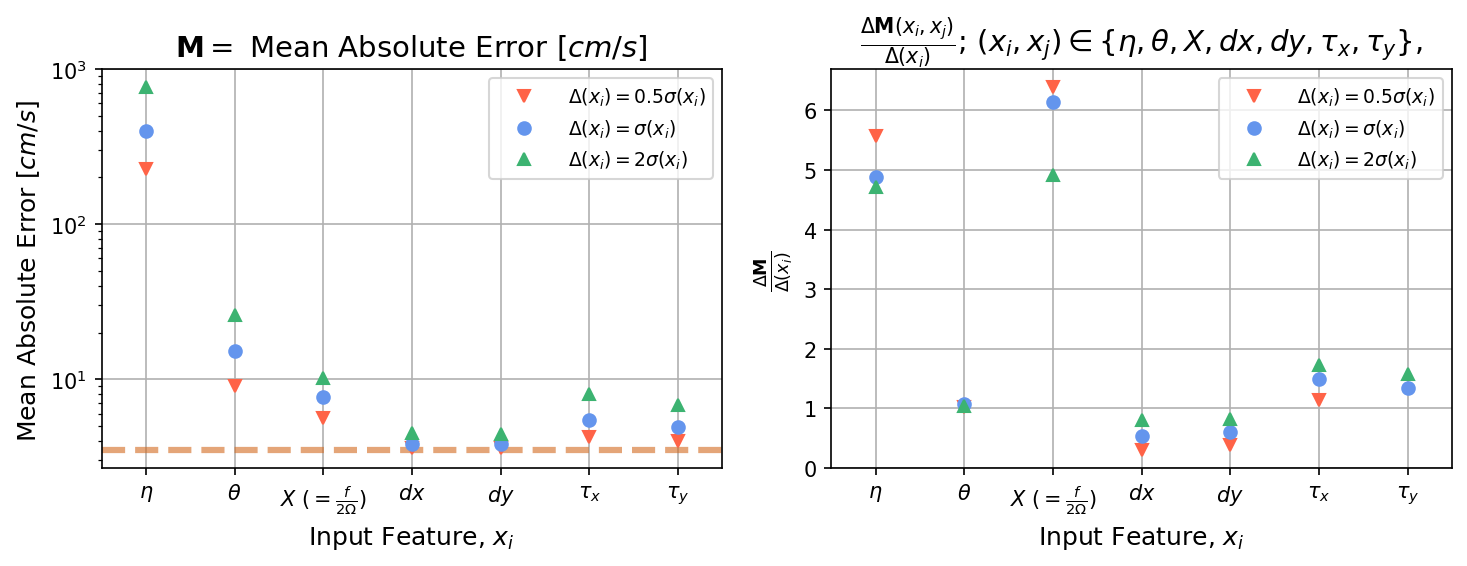

In [83]:
plt.figure(figsize=(10,4), tight_layout=True, dpi = 150)
xlabs = [r'$ \eta$', r'$ \theta$', r'$ X$ $(=\frac{f}{2\Omega})$', r'$ dx$', r'$ dy$', r'$ \tau_x$', r'$ \tau_y$' ]
ylabs = [r'$\Delta(x_i) = 0.5\sigma(x_i)$', r'$\Delta(x_i) = \sigma(x_i)$', r'$\Delta(x_i) =2 \sigma(x_i)$', ]

plt.subplot(121)
plt.plot(np.array(list(mev_ds_mae.values()))[0:-1][2::3], 'v', label= ylabs[0], color=color1)
plt.plot(np.array(list(mev_ds_mae.values()))[0:-1][::3], 'o', label= ylabs[1], color=color2)
plt.plot(np.array(list(mev_ds_mae.values()))[0:-1][1::3], '^', label= ylabs[2], color=color3)
plt.hlines(np.array(list(mev_ds_mae.values()))[-1], -0.5, 6.5, linestyle = 'dashed', linewidth=3, alpha=0.6, color = colors['11'])
plt.xticks([0,1,2,3,4,5,6], xlabs)
plt.xlabel(r'Input Feature, $x_i$ ')
plt.ylabel(r'Mean Absolute Error $[cm/s]$ ')
plt.yscale('log')
plt.xlim([-0.5,6.5])
plt.grid()
plt.legend(fontsize=9)
plt.title(r'$ \mathbf{M} =$ Mean Absolute Error $[cm/s]$')

plt.subplot(122)
plt.plot(np.array(list(dMdvar.values()))[0:-1][2::3], 'v', label= ylabs[0], color=color1,)
plt.plot(np.array(list(dMdvar.values()))[0:-1][::3], 'o', label= ylabs[1], color=color2,)
plt.plot(np.array(list(dMdvar.values()))[0:-1][1::3], '^', label= ylabs[2], color=color3, )
plt.xticks([0,1,2,3,4,5,6], xlabs)
plt.xlabel(r'Input Feature, $x_i$ ')
plt.ylabel(r'$\frac{\Delta \mathbf{M}}{\Delta (x_i)}$ ')
plt.title(r'$\frac{\Delta \mathbf{M}(x_i,x_j)}{\Delta (x_i)}$; $(x_i, x_j) \in \{\eta,\theta,X,dx,dy,\tau_x,\tau_y\}$,' )
plt.xlim([-0.5,6.5])
plt.grid()
plt.legend(fontsize=9)
# plt.title(r'$\frac{\Delta \mathbf{M}}{\Delta \mathbf{x_i}}$, $\mathbf{x_i} \in \{\eta,\theta,X,dx,dy,\tau_x,\tau_y\}$')



Text(0.5, 0.98, '$\\frac{\\Delta \\mathbf{M_k}(x_i,x_j)}{\\Delta (x_i)}$, $(x_i, x_j) \\in \\{\\eta,\\theta,X,dx,dy,\\tau_x,\\tau_y\\} ; \\mathbf{M_k} \\in \\{mae, mse, accuracy\\}$ ')

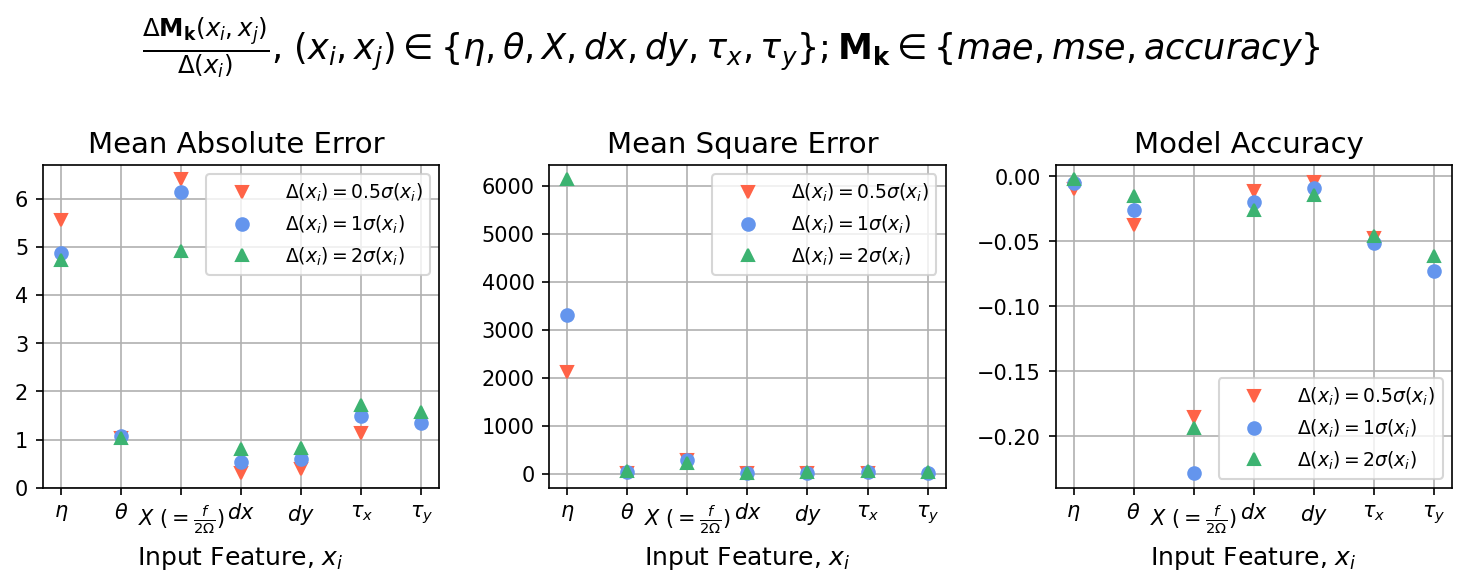

In [78]:
plt.figure(figsize=(10,4), tight_layout=True, dpi = 150)

plt.subplot(131)
plt.plot(np.array(list(dMdvar.values()))[0:-1][2::3], 'v', label= ylabs[0], color=color1)
plt.plot(np.array(list(dMdvar.values()))[0:-1][::3], 'o', label= ylabs[1], color=color2)
plt.plot(np.array(list(dMdvar.values()))[0:-1][1::3], '^', label= ylabs[2], color=color3)
plt.xticks([0,1,2,3,4,5,6], xlabs)
plt.grid()
plt.legend(fontsize=9)
plt.xlabel(r'Input Feature, $x_i$ ')
plt.title(r'Mean Absolute Error ')
# plt.title(r'$\frac{\Delta \mathbf{M}}{\Delta \mathbf{x_i}}$, $\mathbf{x_i} \in \{\eta,\theta,X,dx,dy,\tau_x,\tau_y\}$')


plt.subplot(132)
plt.plot(np.array(list(dMdvar2.values()))[0:-1][2::3], 'v', label= ylabs[0], color=color1)
plt.plot(np.array(list(dMdvar2.values()))[0:-1][::3], 'o', label= ylabs[1], color=color2)
plt.plot(np.array(list(dMdvar2.values()))[0:-1][1::3], '^', label= ylabs[2], color=color3)
plt.xticks([0,1,2,3,4,5,6] , xlabs)
plt.grid()
plt.legend(fontsize=9)
plt.xlabel(r'Input Feature, $x_i$ ')
plt.title(r'Mean Square Error ')
# plt.title(r'$\frac{\Delta \mathbf{M}}{\Delta \mathbf{x_i}}$, $\mathbf{x_i} \in {\eta,\theta,X,dx,dy,\tau_x,\tau_y}$')


plt.subplot(133)
plt.plot(np.array(list(dMdvar3.values()))[0:-1][2::3], 'v', label= ylabs[0], color=color1)
plt.plot(np.array(list(dMdvar3.values()))[0:-1][::3], 'o', label= ylabs[1], color=color2)
plt.plot(np.array(list(dMdvar3.values()))[0:-1][1::3], '^', label= ylabs[2], color=color3)
plt.xticks([0,1,2,3,4,5,6] , xlabs)
plt.grid()
plt.legend(fontsize=9, loc=0)
plt.xlabel(r'Input Feature, $x_i$ ')
plt.title(r'Model Accuracy ')
# plt.title(r'$\frac{\Delta \mathbf{M}}{\Delta \mathbf{x_i}}$, $\mathbf{x_i} \in {\eta,\theta,X,dx,dy,\tau_x,\tau_y}$')

plt.suptitle(r'$\frac{\Delta \mathbf{M_k}(x_i,x_j)}{\Delta (x_i)}$, $(x_i, x_j) \in \{\eta,\theta,X,dx,dy,\tau_x,\tau_y\} ; \mathbf{M_k} \in \{mae, mse, accuracy\}$ ')


Text(0.5, 0.98, '$\\frac{\\Delta \\mathbf{M}}{\\Delta \\mathbf{x_i}}$, $\\mathbf{x_i} \\in \\{\\eta,\\theta,X,dx,dy,\\tau_x,\\tau_y\\}$')

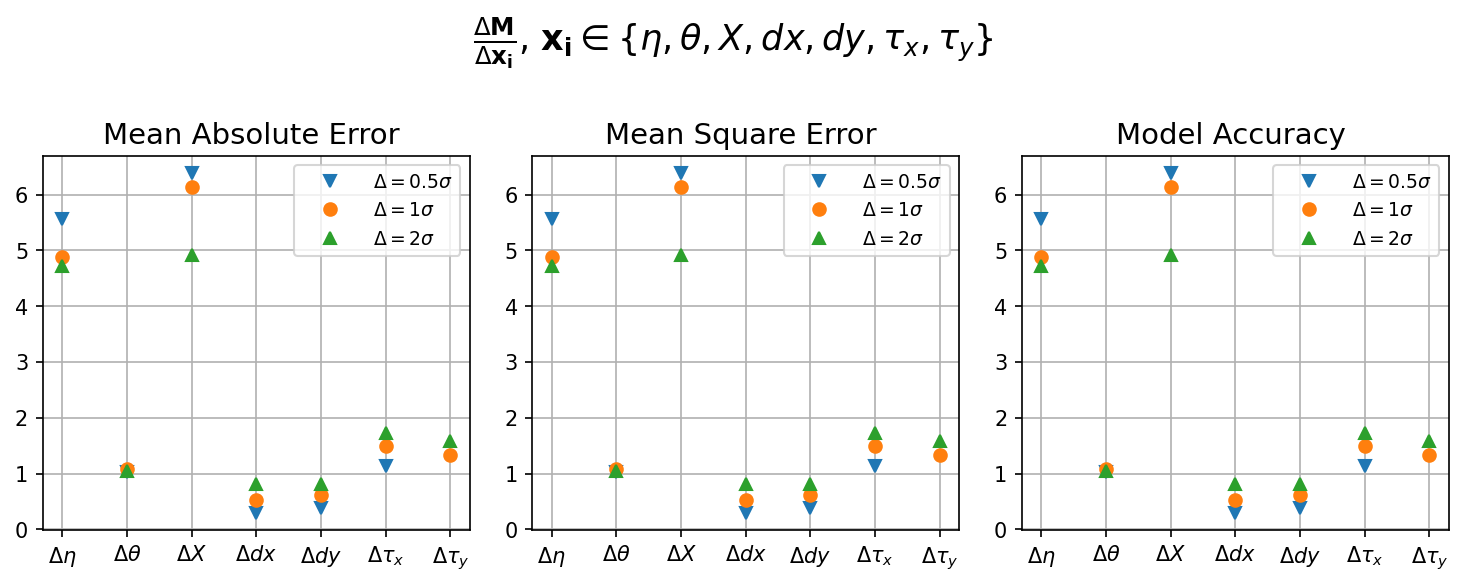

In [52]:
plt.figure(figsize=(10,4), tight_layout=True, dpi = 150)

xlabs = [r'$\Delta \eta$', r'$\Delta \theta$', r'$\Delta X$', r'$\Delta dx$', r'$\Delta dy$', r'$\Delta \tau_x$', r'$\Delta \tau_y$' ]
ylabs = [r'$\Delta = 0.5\sigma$', r'$\Delta = 1\sigma$', r'$\Delta =2 \sigma$', ]

plt.subplot(131)
plt.plot(np.array(list(dMdvar.values()))[0:-1][2::3], 'v', label= ylabs[0])
plt.plot(np.array(list(dMdvar.values()))[0:-1][::3], 'o', label= ylabs[1])
plt.plot(np.array(list(dMdvar.values()))[0:-1][1::3], '^', label= ylabs[2])
plt.xticks([0,1,2,3,4,5,6], xlabs)
plt.grid()
plt.legend(fontsize=9)
plt.title(r'Mean Absolute Error ')
# plt.title(r'$\frac{\Delta \mathbf{M}}{\Delta \mathbf{x_i}}$, $\mathbf{x_i} \in \{\eta,\theta,X,dx,dy,\tau_x,\tau_y\}$')


plt.subplot(132)
plt.plot(np.array(list(dMdvar.values()))[0:-1][2::3], 'v', label= ylabs[0])
plt.plot(np.array(list(dMdvar.values()))[0:-1][::3], 'o', label= ylabs[1])
plt.plot(np.array(list(dMdvar.values()))[0:-1][1::3], '^', label= ylabs[2])
plt.xticks([0,1,2,3,4,5,6] , xlabs)
plt.grid()
plt.legend(fontsize=9)
plt.title(r'Mean Square Error ')
# plt.title(r'$\frac{\Delta \mathbf{M}}{\Delta \mathbf{x_i}}$, $\mathbf{x_i} \in {\eta,\theta,X,dx,dy,\tau_x,\tau_y}$')


plt.subplot(133)
plt.plot(np.array(list(dMdvar.values()))[0:-1][2::3], 'v', label= ylabs[0])
plt.plot(np.array(list(dMdvar.values()))[0:-1][::3], 'o', label= ylabs[1])
plt.plot(np.array(list(dMdvar.values()))[0:-1][1::3], '^', label= ylabs[2])
plt.xticks([0,1,2,3,4,5,6] , xlabs)
plt.grid()
plt.legend(fontsize=9)
plt.title(r'Model Accuracy ')
# plt.title(r'$\frac{\Delta \mathbf{M}}{\Delta \mathbf{x_i}}$, $\mathbf{x_i} \in {\eta,\theta,X,dx,dy,\tau_x,\tau_y}$')

plt.suptitle(r'$\frac{\Delta \mathbf{M}}{\Delta \mathbf{x_i}}$, $\mathbf{x_i} \in \{\eta,\theta,X,dx,dy,\tau_x,\tau_y\}$')
